<a href="https://colab.research.google.com/github/Selva-Subramanian/Zomato-restaurant-clustering-Sentiment-Analysis/blob/main/ZOMATO_RESTAURANT_CLUSTERING_AND_SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

Zomato is an Indian restaurant aggregator and food delivery start-up founded by Deepinder Goyal and Pankaj Chaddah in 2008. Zomato provides information, menus and user-reviews of restaurants, and also has food delivery options from partner restaurants in select cities.

India is quite famous for its diverse multi cuisine available in a large number of restaurants and hotel resorts, which is reminiscent of unity in diversity. Restaurant business in India is always evolving. More Indians are warming up to the idea of eating restaurant food whether by dining outside or getting food delivered. The growing number of restaurants in every state of India has been a motivation to inspect the data to get some insights, interesting facts and figures about the Indian food industry in each city. So, this project focuses on analysing the Zomato restaurant data for each city in India.

The Project focuses on Customers and Company, you have  to analyze the sentiments of the reviews given by the customer in the data and made some useful conclusion in the form of Visualizations. Also, cluster the zomato restaurants into different segments. The data is vizualized as it becomes easy to analyse data at instant. The Analysis also solve some of the business cases that can directly help the customers finding the Best restaurant in their locality and for the company to grow up and work on the fields they are currently lagging in.

This could help in clustering the restaurants into segments. Also the data has valuable information around cuisine and costing which can be used in cost vs. benefit analysis

Data could be used for sentiment analysis. Also the metadata of reviewers can be used for identifying the critics in the industry. 

# **Attribute Information**

## **Zomato Restaurant names and Metadata**
Use this dataset for clustering part

1. Name : Name of Restaurants

2. Links : URL Links of Restaurants

3. Cost : Per person estimated Cost of dining

4. Collection : Tagging of Restaurants w.r.t. Zomato categories

5. Cuisines : Cuisines served by Restaurants

6. Timings : Restaurant Timings

## **Zomato Restaurant reviews**
Merge this dataset with Names and Matadata and then use for sentiment analysis part

1. Restaurant : Name of the Restaurant

2. Reviewer : Name of the Reviewer

3. Review : Review Text

4. Rating : Rating Provided by Reviewer

5. MetaData : Reviewer Metadata - No. of Reviews and followers

6. Time: Date and Time of Review

7. Pictures : No. of pictures posted with review

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# importing the required libraries
import numpy as np # for numerical computation
import pandas as pd # for data manipulation
import math

%matplotlib inline
import matplotlib.pyplot as plt # for plotting visuals
import seaborn as sns

In [3]:
working_dir_path = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/CP4 - Unsupervised - Clustering/'
df1 = pd.read_csv(working_dir_path + 'Zomato Restaurant names and Metadata.csv')
df2 = pd.read_csv(working_dir_path + 'Zomato Restaurant reviews.csv')

In [ ]:
df1.head()

,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,Late Night Restaurants,"Biryani, North Indian, Chinese, Seafood, Bever...",12 Noon to 2 AM
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,"1,200","Best Bars & Pubs, Food Hygiene Rated Restauran...","Asian, Continental, North Indian, Chinese, Med...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no..."


In [11]:
dfg = gower.gower_matrix(df1)

In [14]:
dfg.shape

(105, 105)

In [18]:
dfg[0]

array([0.       , 0.8333333, 1.       , 0.8333333, 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 0.8333333,
       1.       , 1.       , 0.8333333, 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    object
 3   Collections  51 non-null     object
 4   Cuisines     105 non-null    object
 5   Timings      104 non-null    object
dtypes: object(6)
memory usage: 5.0+ KB


In [ ]:
df2.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


In [ ]:
x = df1.iloc[:, [0,2]]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 196.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 196.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 196.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 196.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 196.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 194.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 195.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, it

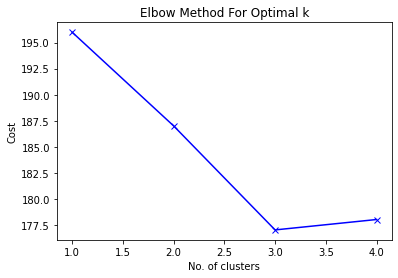

In [ ]:
# Elbow curve to find optimal K
cost = []
K = range(1,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(x)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
x.insert(0, "Cluster", clusters, True)
x

,Cluster,Name,Cost
0,0,Beyond Flavours,800
1,0,Paradise,800
2,0,Flechazo,"1,300"
3,0,Shah Ghouse Hotel & Restaurant,800
4,0,Over The Moon Brew Company,"1,200"
...,...,...,...
100,0,IndiBlaze,600
101,0,Sweet Basket,200
102,2,Angaara Counts 3,500
103,0,Wich Please,250


In [24]:
# Install gower
!pip install gower

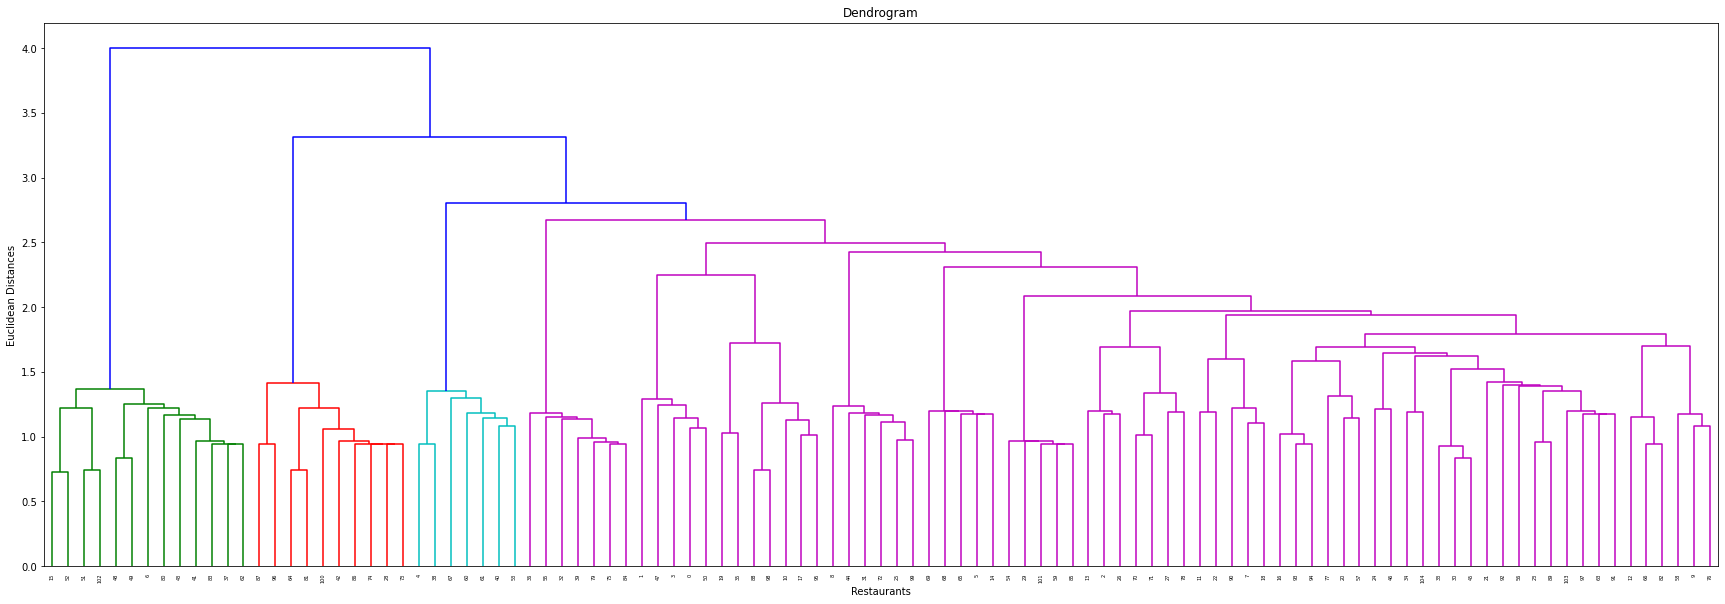

In [29]:
# Plot dendrogram
import gower
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(30,10))
dendrogram = sch.dendrogram(sch.linkage(dfg, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Restaurants')
plt.ylabel('Euclidean Distances')
plt.show()